In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
manual_seed = 42
torch.manual_seed(manual_seed)

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Set parameters
image_size = 64
batch_size = 128
nz = 100 # size of the latent z vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator
nc = 3 # number of channels in the training images

# Create the generator
netG = Generator(nz, ngf, nc)

# Create the discriminator
netD = Discriminator(nc, ndf)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load the dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root="C:\\Users\\User\\Desktop\\Notable image\\CelebA FR Triplets\\CelebA FR Triplets", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# Training Loop with tqdm
num_epochs = 20
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device:", device)

netG.to(device)
netD.to(device)

for epoch in range(num_epochs):
    loop = tqdm(enumerate(dataloader, 0), total=len(dataloader), leave=True)
    for i, data in loop:
        # Update Discriminator network
        netD.zero_grad()
        real_cpu = data[0].to(device)  # Convert real data to the device (GPU/CPU)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator network
        netG.zero_grad()
        label.fill_(1)  
        output = netD(fake).view(-1)
        errG = criterion(output, label.to(torch.float))
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(D_real=D_x, D_fake=D_G_z1, Loss_D=errD.item(), Loss_G=errG.item())

#         if i % 100 == 0:
#             vutils.save_image(real_cpu,
#                     '%s/real_samples.png' % "./results",
#                     normalize=True)
#             fake = netG(noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % ("./results", epoch),
#                     normalize=True)


# # Generate some images using the trained generator
# num_test_samples = 16
# noise = torch.randn(num_test_samples, nz, 1, 1, device=device)
# fake_images = netG(noise).detach().cpu()
# plt.figure(figsize=(10, 10))
# plt.axis("off")
# plt.title("Generated Images")
# plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
# plt.show()


Device: cuda:0


Epoch [20/20]: 100%|██████| 363/363 [00:20<00:00, 17.60it/s, D_fake=0.000986, D_real=0.997, Loss_D=0.0036, Loss_G=7.29]


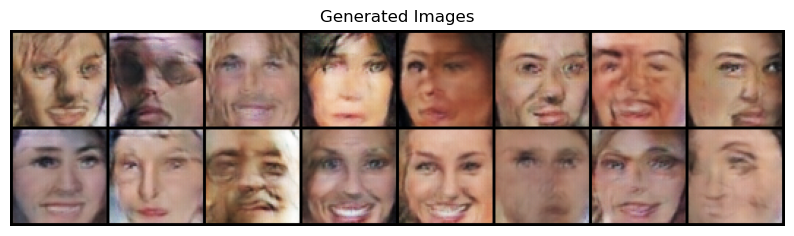

In [11]:
# Generate some images using the trained generator

import numpy as np 

num_test_samples = 16
noise = torch.randn(num_test_samples, nz, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()